# Imports

In [13]:
%load_ext autoreload
%autoreload all
import os
os.chdir("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.gridspec as gridspec
from Utils.Settings import neuron_cluster_groups_order,output_folder_calculations, order_broad_division, class_to_division, class_to_broad_division, genes_families, neuron_cluster_groups_order, manifest, download_base, output_folder, output_folder_supplementary, family_name, threshold_expression 
from Utils.Utils import broad_division_color_map, genes_cmap_rgb, cluster_groups_cmap, genes_cmap, percentage_above_threshold
import matplotlib.colors as mcolors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import shap
from sklearn.metrics import confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure horizontal scrollability
pd.set_option('display.max_colwidth', None) 

# Load data

In [15]:
%%time
metadata = manifest['file_listing']['WMB-10X']['metadata']

rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath )
cell = pd.read_csv(file, keep_default_na=False)
cell.set_index('cell_label',inplace=True)

matrices = cell.groupby(['dataset_label','feature_matrix_label'])[['library_label']].count()
matrices.columns  = ['cell_count']


rpath = metadata['example_genes_all_cells_expression']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath.replace('example_genes_all_cells_expression.csv', f'{family_name}_genes_all_cells_expression.csv'))
exp = pd.read_csv(file)
exp.set_index('cell_label',inplace=True)
exp = exp.sort_index(axis=1)


CPU times: user 28.6 s, sys: 4.24 s, total: 32.8 s
Wall time: 32.8 s


In [16]:
exp_with_tot = exp.copy()
exp_with_tot["Any Htr"] = exp[exp>threshold_expression].any(axis=1).replace({True: 10})


# Process

In [17]:
cell["division"] = cell['class'].map(class_to_division)
cell["broad_division"] = cell['class'].map(class_to_broad_division)

metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['cluster_group_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
group_membership = pd.read_csv(file) # cluster can belong to two different groups


metadata = manifest['file_listing']['WMB-taxonomy']['metadata']

rpath = metadata['cluster_annotation_term_set']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
term_set = pd.read_csv(file)
term_set

label              name  \
0  CCN20230722_NEUR  neurotransmitter   
1  CCN20230722_CLAS             class   
2  CCN20230722_SUBC          subclass   
3  CCN20230722_SUPT         supertype   
4  CCN20230722_CLUS           cluster   

                                                                                                                                                                                                                                                         description  \
0                                                                                                               Clusters are assigned based on the average expression of both neurotransmitter transporter genes and key neurotransmitter synthesizing enzyme genes.   
1  The top level of cell type definition in the mouse whole brain taxonomy. It is primarily determined by broad brain region and neurotransmitter type. All cells within a subclass belong to the same class. Class provides a broader categorization of cell types.   
2                                                                                 The coarse level of cell type definition in the mouse whole brain taxonomy. All cells within a supertype belong to the same subclass. Subclass groups together related supertypes.   
3                                                                            The second finest level of cell type definition in the mouse whole brain taxonomy. All cells within a cluster belong to the same supertype. Supertype groups together similar clusters.   
4                                                                                                 The finest level of cell type definition in the mouse whole brain taxonomy. Cells within a cluster share similar characteristics and belong to the same supertype.   

   order  
0      0  
1      1  
2      2  
3      3  
4      4

In [18]:
group_membership

cluster_label       cluster_group_label  cluster_alias  \
0      CS20230722_0128  CCN20230722_Pallium-Glut            128   
1      CS20230722_0128    CCN20230722_WholeBrain            128   
2      CS20230722_0129  CCN20230722_Pallium-Glut            129   
3      CS20230722_0129    CCN20230722_WholeBrain            129   
4      CS20230722_0130  CCN20230722_Pallium-Glut            130   
...                ...                       ...            ...   
11156  CS20230722_5272    CCN20230722_WholeBrain           5272   
11157  CS20230722_5274     CCN20230722_NN-IMN-GC           5274   
11158  CS20230722_5274    CCN20230722_WholeBrain           5274   
11159  CS20230722_5273     CCN20230722_NN-IMN-GC           5273   
11160  CS20230722_5273    CCN20230722_WholeBrain           5273   

      cluster_group_name  
0           Pallium-Glut  
1             WholeBrain  
2           Pallium-Glut  
3             WholeBrain  
4           Pallium-Glut  
...                  ...  
11156         WholeBrain  
11157          NN-IMN-GC  
11158         WholeBrain  
11159          NN-IMN-GC  
11160         WholeBrain  

[11161 rows x 4 columns]

# Main divisions

In [19]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['dimension_reduction']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
maps = pd.read_csv(file)
maps.set_index('name',inplace=True)
print("number of maps:",len(maps))
maps

number of maps: 8


label  \
name                                                      
HY-EA-Glut-GABA            UMAP20230830-HY-EA-Glut-GABA   
MB-HB-CB-GABA                UMAP20230830-MB-HB-CB-GABA   
MB-HB-Glut-Sero-Dopa  UMAP20230830-MB-HB-Glut-Sero-Dopa   
NN-IMN-GC                        UMAP20230830-NN-IMN-GC   
Pallium-Glut                  UMAP20230830-Pallium-Glut   
Subpallium-GABA            UMAP20230830-Subpallium-GABA   
TH-EPI-Glut                    UMAP20230830-TH-EPI-Glut   
WholeBrain                      UMAP20230830-WholeBrain   

                                                                                                                                                                                                             description  \
name                                                                                                                                                                                                                       
HY-EA-Glut-GABA                                       Glutamatergic and GABAergic neurons in hypothalamus and extended amygdala, also including all non-pallium glutamatergic neurons in cerebral nuclei (1404 clusters)   
MB-HB-CB-GABA                                                                                                                                   GABAergic neurons in midbrain, hindbrain, and cerebellum (1040 clusters)   
MB-HB-Glut-Sero-Dopa                                                                                                      Glutamatergic, serotonergic and dopaminergic neurons in midbrain and hindbrain (1431 clusters)   
NN-IMN-GC                                                                Non-neuronal cells, immature neurons, granule cells in dentate gyrus, olfactory bulb and cerebellum, and neurons in pineal gland (248 clusters)   
Pallium-Glut                      Glutamatergic neurons from cerebral cortex (derived from the developmental pallium), including isocortex, hippocampal formation, olfactory areas, and cortical subplate (517 clusters)   
Subpallium-GABA       Telencephalic GABAergic neurons from cerebral cortex and cerebral nuclei, as well as some from the hypothalamic preoptic area, which are derived from the developmental subpallium (1051 clusters)   
TH-EPI-Glut                                                                                                       Glutamatergic neurons from thalamus and epithalamus (i.e., medial and lateral habenula) (148 clusters)   
WholeBrain                                                                                                                                                            All cells in the whole mouse brain (5322 clusters)   

                      number_of_cells               cluster_group_label  
name                                                                     
HY-EA-Glut-GABA                295448       CCN20230722_HY-EA-Glut-GABA  
MB-HB-CB-GABA                  186775         CCN20230722_MB-HB-CB-GABA  
MB-HB-Glut-Sero-Dopa           180669  CCN20230722_MB-HB-Glut-Sero-Dopa  
NN-IMN-GC                     1418529             CCN20230722_NN-IMN-GC  
Pallium-Glut                  1494801          CCN20230722_Pallium-Glut  
Subpallium-GABA                611423       CCN20230722_Subpallium-GABA  
TH-EPI-Glut                    126171           CCN20230722_TH-EPI-Glut  
WholeBrain                    4042976            CCN20230722_WholeBrain

In [20]:
cell_with_membership = cell.reset_index().merge(group_membership[["cluster_group_label", "cluster_alias", "cluster_group_name"]], on='cluster_alias').set_index("cell_label")

cell_with_membership["cluster_group_color"] = cell_with_membership["cluster_group_name"].map(cluster_groups_cmap)

cell_with_membership = cell_with_membership[cell_with_membership['cluster_group_name']!="WholeBrain"]
cell['broad_division_color'] = cell['broad_division'].map(broad_division_color_map)

selected_genes = exp_with_tot.columns.sort_values()

joined = cell.join(exp_with_tot)

joined_boolean =  cell.join(exp_with_tot>threshold_expression)

subsampled = joined.loc[::30]

In [21]:
# CAREFUL assigning membership to neighborood will duplicate some cells
joined_with_membership = cell_with_membership.join(exp_with_tot)

joined_boolean_with_membership =  cell_with_membership.join(exp_with_tot>threshold_expression)
subsampled_with_membership = joined_with_membership.loc[::30]

In [22]:
expression_by_neurotransmitter = round(joined.groupby("neurotransmitter")[selected_genes].apply(percentage_above_threshold), 2)

In [23]:
expression_by_group = round(joined_with_membership.groupby("cluster_group_name")[selected_genes].apply(percentage_above_threshold), 2)

In [24]:
expression_by_class = round(joined_with_membership.groupby("class")[selected_genes].apply(percentage_above_threshold), 2)

In [25]:
expression_by_subclass = round(joined_with_membership.groupby("subclass")[selected_genes].apply(percentage_above_threshold), 2)

In [26]:

# Convert the DataFrame to a NumPy array
corr_matrix_np = expression_by_neurotransmitter.T.corr().to_numpy()

# Replace the diagonal elements with NaN
np.fill_diagonal(corr_matrix_np, np.nan)

# Convert the NumPy array back to a DataFrame if needed
corr_by_neurotransmitter = pd.DataFrame(corr_matrix_np, index=expression_by_neurotransmitter.index, columns=expression_by_neurotransmitter.index)


# Convert the DataFrame to a NumPy array
corr_matrix_np = expression_by_group.T.corr().to_numpy()

# Replace the diagonal elements with NaN
np.fill_diagonal(corr_matrix_np, np.nan)

# Convert the NumPy array back to a DataFrame if needed
corr_by_group = pd.DataFrame(corr_matrix_np, index=expression_by_group.index, columns=expression_by_group.index)

# Convert the DataFrame to a NumPy array
corr_matrix_np = expression_by_class.T.corr().to_numpy()

# Replace the diagonal elements with NaN
np.fill_diagonal(corr_matrix_np, np.nan)

# Convert the NumPy array back to a DataFrame if needed
corr_by_class = pd.DataFrame(corr_matrix_np, index=expression_by_class.index, columns=expression_by_class.index)


In [27]:
neurotransmitter_color_map = {}
for n in cell['neurotransmitter'].unique():
    neurotransmitter_color_map[n] = cell[cell['neurotransmitter'] == n]['neurotransmitter_color'][0]
genes_cmap_rgb["Any Htr"] = "#494949"

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [28]:
classification_cmap = joined.drop_duplicates(subset='subclass').set_index('subclass')['subclass_color'].to_dict()
classification_cmap.update(joined.drop_duplicates(subset='supertype').set_index('supertype')['subclass_color'].to_dict())
classification_cmap.update(joined.drop_duplicates(subset='cluster').set_index('cluster')['subclass_color'].to_dict())
classification_cmap.update(joined.drop_duplicates(subset='class').set_index('class')['class_color'].to_dict())


In [132]:
fam_cmap = {
    "Htr1/5": "#6a5acd",  # Slate Blue
    "Htr2": "#ff6347",   # Tomato Red
    "Htr4/6/7": "#ffd700",  # Gold
    "Htr3": "#20b2aa"    # Light Sea Green
}


In [133]:
general_cmap = genes_cmap_rgb | neurotransmitter_color_map | cluster_groups_cmap | classification_cmap | fam_cmap

In [30]:
_ = joined_boolean_with_membership

at_least_2_receptors_per_group = {}
for area in _['cluster_group_name'].unique():
    at_least_2_receptors_per_group[area] = (np.sum(_[_['cluster_group_name']==area][selected_genes[selected_genes!='Any Htr']].sum(axis=1)>=2)/np.sum(_[_['cluster_group_name']==area][selected_genes[selected_genes!='Any Htr']].sum(axis=1)>=1))*100



In [31]:
joined.columns

Index(['cell_barcode', 'barcoded_cell_sample_label', 'library_label',
       'feature_matrix_label', 'entity', 'brain_section_label',
       'library_method', 'region_of_interest_acronym', 'donor_label',
       'donor_genotype', 'donor_sex', 'dataset_label', 'x', 'y',
       'cluster_alias', 'neurotransmitter', 'class', 'subclass', 'supertype',
       'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color',
       'supertype_color', 'cluster_color', 'region_of_interest_order',
       'region_of_interest_color', 'division', 'broad_division',
       'broad_division_color', 'Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a',
       'Htr2b', 'Htr2c', 'Htr3a', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6',
       'Htr7', 'Any Htr'],
      dtype='object')

In [32]:
_ = joined_boolean_with_membership

at_least_2_receptors_per_group_and_gene = {}
for area in tqdm(joined_boolean_with_membership['cluster_group_name'].unique()):
    __ = joined_boolean_with_membership[joined_boolean_with_membership['cluster_group_name']==area]  
    for gene in selected_genes:
        at_least_2_receptors_per_group_and_gene[area,gene] = (np.sum(__[__[gene]==True][selected_genes[selected_genes!='Any Htr']].sum(axis=1)>=2)/np.sum(__[__[gene]==True][selected_genes[selected_genes!='Any Htr']].sum(axis=1)>=1))*100



  0%|          | 0/7 [00:00<?, ?it/s]

In [33]:
_ = joined_boolean[selected_genes[selected_genes!='Any Htr']]

In [34]:
at_least_2_receptors = {}
for gene in selected_genes[selected_genes!='Any Htr']:
    at_least_2_receptors[gene] = (np.sum(_[_[gene]==True].sum(axis=1)>=2)/np.sum(_[_[gene]==True].sum(axis=1)>=1))*100

at_least_3_receptors = {}
for gene in selected_genes[selected_genes!='Any Htr']:
    at_least_3_receptors[gene] = (np.sum(_[_[gene]==True].sum(axis=1)>=3)/np.sum(_[_[gene]==True].sum(axis=1)>=1))*100

at_least_4_receptors = {}
for gene in selected_genes[selected_genes!='Any Htr']:
    at_least_4_receptors[gene] = (np.sum(_[_[gene]==True].sum(axis=1)>=4)/np.sum(_[_[gene]==True].sum(axis=1)>=1))*100

at_least_5_receptors = {}
for gene in selected_genes[selected_genes!='Any Htr']:
    at_least_5_receptors[gene] = (np.sum(_[_[gene]==True].sum(axis=1)>=5)/np.sum(_[_[gene]==True].sum(axis=1)>=1))*100

In [35]:
at_least_2_receptors

{'Htr1a': 91.22923440357651,
 'Htr1b': 91.33249250693274,
 'Htr1d': 94.81127082583568,
 'Htr1f': 69.30762900291646,
 'Htr2a': 84.41670704031415,
 'Htr2b': 80.33565853995441,
 'Htr2c': 81.29387870218416,
 'Htr3a': 85.46000268789105,
 'Htr3b': 87.13182728052617,
 'Htr4': 86.93457673583833,
 'Htr5a': 90.96397349954918,
 'Htr5b': 90.14163791538043,
 'Htr6': 88.69143551898662,
 'Htr7': 87.7206165230132}

## Co-exp

In [218]:
# coexp = {}
# for gene_target in tqdm(selected_genes[selected_genes!='Any Htr']):
#     for gene_to_check in selected_genes[selected_genes!='Any Htr']: 
#         coexp[gene_target, gene_to_check] = joined_boolean[[gene_target, gene_to_check]].all(axis=1).sum()/(joined_boolean[gene_target]>0).sum()

  0%|          | 0/14 [00:00<?, ?it/s]

In [219]:
# coloc = pd.DataFrame.from_dict(coexp, orient='index', columns=['Colocalized (%)'])
# coloc[['Gene1', 'Gene2']] = pd.DataFrame(coloc.index.tolist(), index=coloc.index)
# coloc = coloc.reset_index(drop=True)

# # Reorder the columns for clarity
# coloc = coloc[['Gene1', 'Gene2', 'Colocalized (%)']]
# coloc["Colocalized (%)"] = coloc["Colocalized (%)"] * 100

# coloc['Gene1'] = pd.Categorical(coloc['Gene1'], categories=selected_genes[selected_genes!='Any Htr'], ordered=True)

# coloc['Gene2'] = pd.Categorical(coloc['Gene2'], categories=selected_genes[selected_genes!='Any Htr'], ordered=True)

In [220]:
#coloc.to_pickle(f"{output_folder_calculations}/total_colocalization_{family_name}.pkl")

In [39]:
coloc = pd.read_pickle(f"{output_folder_calculations}/total_colocalization_{family_name}.pkl")

# Expression genes

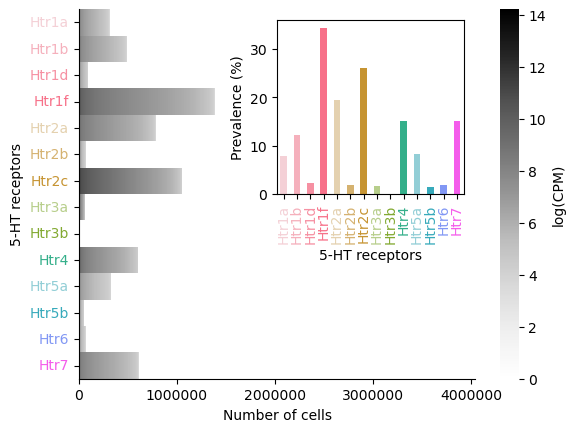

In [40]:
def expr_genes_whole_brain(ax, exp):
    sns.heatmap(pd.DataFrame(np.sort(exp.values, axis=0)[::-200], columns=exp.columns, 
                                  index=exp.reset_index().index[::200]).T, xticklabels=5000, cbar_kws={'label': 'log(CPM)'}, cmap="Greys", ax=ax)
    ax.set_xlabel("Number of cells")
    ax.set_ylabel("5-HT receptors")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    colors_list = [genes_cmap_rgb[receptor] for receptor in exp.columns]
    
    for ytick in ax.get_yticklabels():
        ytick.set_color(genes_cmap_rgb[ytick.get_text()])
    
    axins = ax.inset_axes( [0.5, 0.5, 0.47, 0.47])
    (((exp>threshold_expression).sum(axis=0)/exp.shape[0])*100).plot.bar(ax=axins, color=colors_list)
    axins.set_xlabel("5-HT receptors")
    axins.set_ylabel("Prevalence (%)")
    
    for xtick in axins.get_xticklabels():
        xtick.set_color(genes_cmap_rgb[xtick.get_text()])

fig, ax = plt.subplots()
expr_genes_whole_brain(ax, exp)

## Difference between UMAP distribtion

In [41]:
def diff_umap_ABC_groups(axs):
    _ = subsampled_with_membership.dropna()
    
    legend_handles = []
    
    # Create a Patch (a colored box) for each name and color, and add it to legend_handles
    for name in neuron_cluster_groups_order:
        legend_handles.append(mpatches.Patch(color=cluster_groups_cmap[name], label=name))
    
    axs.legend(handles=legend_handles, title='Neighborhoods', ncol=3, loc='upper left', bbox_to_anchor=(0, 1.18),
             handlelength=.5, handletextpad=0.1, borderaxespad=0.1, framealpha=.2)
    
    axs.scatter(_['x'], _['y'], c=_["cluster_group_color"], s=0.5, marker='.')
    axs.axis('off')


In [42]:
def diff_umap(axs):
    _ = subsampled.dropna()

    axs[1].scatter(_['x'], _['y'], c=_[genes_families[list(genes_families.keys())[0]]].max(axis=1), s=0.5, marker='.', cmap="Reds")
    
    axs[1].axis('off')
    axs[1].set_title(f'{list(genes_families.keys())[0]} family')
    
    axs[2].scatter(_['x'], _['y'], c=_[genes_families[list(genes_families.keys())[1]]].max(axis=1), s=0.5, marker='.', cmap='YlOrBr')
    
    axs[2].axis('off')
    axs[2].set_title(f'{list(genes_families.keys())[1]} family')


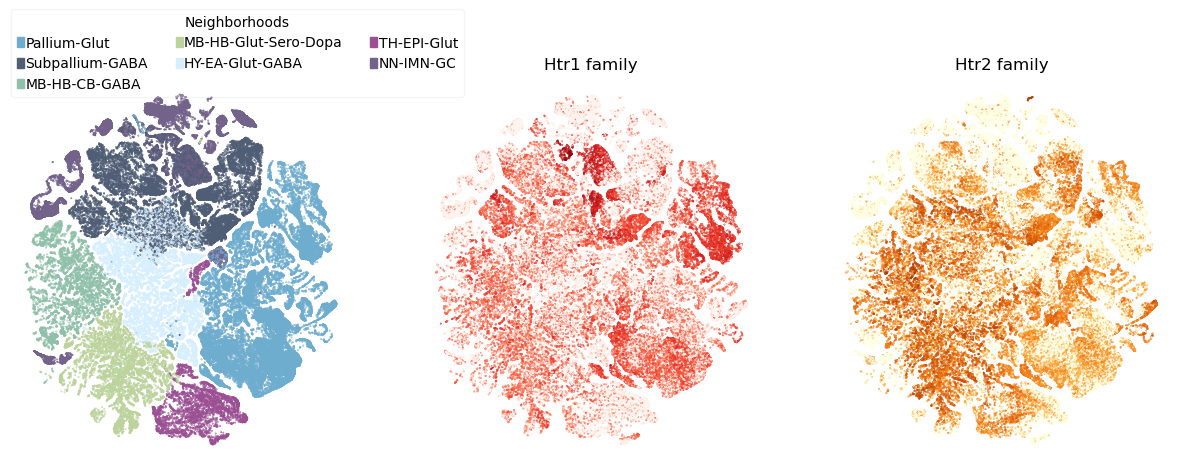

In [43]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
diff_umap(axs)
diff_umap_ABC_groups(axs[0])

In [44]:
selected_genes

Index(['Any Htr', 'Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2b',
       'Htr2c', 'Htr3a', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7'],
      dtype='object')

## Decoding power

In [45]:
%%time
sel = "neurotransmitter"#"cluster_group_name"#"neurotransmitter"

def decoddddddd(joined_boolean, sel):
    df = joined_boolean[[sel]+list(selected_genes)]
    
    df.set_index(sel, inplace=True)
    
    # Assuming 'df' is your DataFrame
    X = df # Features (Htr expression levels)
    y = df.index  # Target (neurotransmitter type)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, stratify=y)
    
    
    # Initialize the Random Forest classifier
    # You can adjust 'n_estimators' and 'max_depth' based on your dataset and computational resources
    rf_classifier = RandomForestClassifier(n_estimators=10, max_depth=10, n_jobs=30, class_weight='balanced')
    #rf_classifier = HistGradientBoostingClassifier( class_weight='balanced')
    
    # Train the model
    rf_classifier.fit(X_train, y_train)
    
    
    # Make predictions
    y_pred = rf_classifier.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)*100
    print("Accuracy:", accuracy)
    report = classification_report(y_test, y_pred, output_dict=True)
    print("\nClassification Report:\n",  classification_report(y_test, y_pred))
     
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    
    cm = pd.DataFrame(cm, columns=y_test.astype("category").categories, index=y_test.astype("category").categories)*100
    
    X_sample = X_test.sample(n=10000, weights=y_test.map(10000/y_test.value_counts()), random_state=4)
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(rf_classifier, n_jobs=40)
    shap_values = explainer.shap_values(X_sample)
    
    
    out=[]
    for i in range(len(shap_values)):
        out.append(pd.Series( np.abs(shap_values[i]).mean(0), name=sorted(joined_boolean[sel].unique())[i], index=X_test.columns))
    
    shap_matrix = pd.concat(out, axis=1).T

    return cm, shap_matrix, accuracy, report

cm_neurotransmitter, shap_matrix_neurotransmitter, accuracy_neurotransmitter, report = decoddddddd(joined_boolean, sel)

Accuracy: 36.99647289870343

Classification Report:
               precision    recall  f1-score   support

                   0.63      0.80      0.70     54682
        Chol       0.03      0.49      0.05       369
        Dopa       0.01      0.21      0.02       411
        GABA       0.62      0.11      0.19     41691
   GABA-Glyc       0.04      0.45      0.08      1783
        Glut       0.79      0.25      0.38    102680
   Glut-GABA       0.02      0.12      0.03       402
        Hist       0.00      0.41      0.00        27
        Nora       0.00      0.48      0.00        31
        Sero       0.01      0.82      0.01        73

    accuracy                           0.37    202149
   macro avg       0.21      0.41      0.15    202149
weighted avg       0.70      0.37      0.42    202149

CPU times: user 1min 42s, sys: 2.41 s, total: 1min 44s
Wall time: 1min 14s


In [46]:
cm_neurotransmitter

Chol       Dopa       GABA  GABA-Glyc       Glut  \
           79.816027   0.786365   0.821111   0.157273   0.087780   2.578545   
Chol        8.943089  49.322493   3.523035   0.813008   9.214092   4.065041   
Dopa       14.598540   2.676399  20.681265   1.946472  18.734793   5.596107   
GABA       15.000840   3.924108   5.473603  11.083927  17.274712  12.031374   
GABA-Glyc   4.318564   2.972518   6.337633   3.869882  44.924285   5.047672   
Glut       18.843981   4.099143   5.320413   2.623685  10.184067  24.659135   
Glut-GABA  11.194030   4.477612   7.711443   4.975124  20.149254   7.711443   
Hist       14.814815   7.407407   7.407407   0.000000  14.814815   7.407407   
Nora       22.580645   6.451613   3.225806   0.000000   3.225806   6.451613   
Sero        0.000000   0.000000   0.000000   2.739726   6.849315   5.479452   

           Glut-GABA       Hist       Nora       Sero  
            0.020116   5.753264   9.718006   0.261512  
Chol        0.271003   7.046070   7.317073   9.485095  
Dopa        3.163017  19.464720   9.002433   4.136253  
GABA        4.353458  11.690773  13.379386   5.787820  
GABA-Glyc   2.860348  15.928211   4.038138   9.702748  
Glut        1.172575  11.394624  14.917219   6.785158  
Glut-GABA  11.940299  18.905473   4.975124   7.960199  
Hist        0.000000  40.740741   0.000000   7.407407  
Nora        0.000000   9.677419  48.387097   0.000000  
Sero        1.369863   0.000000   1.369863  82.191781

## Expression across neurotransmitter types and regions 

In [47]:
sel = "neurotransmitter"
def expr_genes_by_sel(axs, sel, joined, cm, shap_matrix):

    cax = sns.heatmap(joined.groupby(sel)[selected_genes].apply(percentage_above_threshold),
            yticklabels=True, cmap=sns.light_palette("#CC5656", as_cmap=True), ax=axs[0],vmax=90, cbar_kws={'label': 'Prevalence (%)', "shrink": 0.5, "location": "right", "pad":0.05})

    # ax.set_xticklabels([])  # Remove xticklabels
    # ax.set_ylabel("") 
    # ax.tick_params(axis='y', rotation=45)
    # ax.set_yticklabels(ax.get_yticklabels(), va="top")


    sns.heatmap(cm, cmap="Blues", ax=axs[1], cbar_kws={'label': 'Probability (%)', "shrink": 0.5, "location": "right", "pad":0.05})
    axs[1].set_title('Confusion Matrix')
    axs[1].set_xlabel('Predicted Label')
    axs[1].set_ylabel('True Label')

    sns.heatmap(shap_matrix, cmap="Purples", ax=axs[2], cbar_kws={'label': 'Mean |SHAP value|', "shrink": 0.5, "location": "right", "pad":0.05})
    axs[2].set_title('|SHAP value| matrix')
    axs[0].set_title('Htr expression')

    
    for ax in axs:
        for ytick in ax.get_xticklabels():
            if ytick.get_text() in list(general_cmap.keys()):
                ytick.set_color(general_cmap[ytick.get_text()])
        for ytick in ax.get_yticklabels():
            if ytick.get_text() in list(general_cmap.keys()):
                ytick.set_color(general_cmap[ytick.get_text()])

    
fig, axs = plt.subplots(3,1, figsize=(5,10))
sel = "neurotransmitter"
expr_genes_by_sel(axs, sel,joined, cm_neurotransmitter, shap_matrix_neurotransmitter)
fig.subplots_adjust(hspace=0.8) 
#fig.tight_layout(pad=0.5)
# Get current position of the middle subplot
pos = axs[1].get_position()

# Modify the position parameters as needed (left, bottom, width, height)
# For example, to move the subplot up and increase its height:
new_pos = [pos.x0, pos.y0 + 0.02, pos.width, pos.height + 0.02]

# Set the new position
axs[1].set_position(new_pos)


## Expression across classes

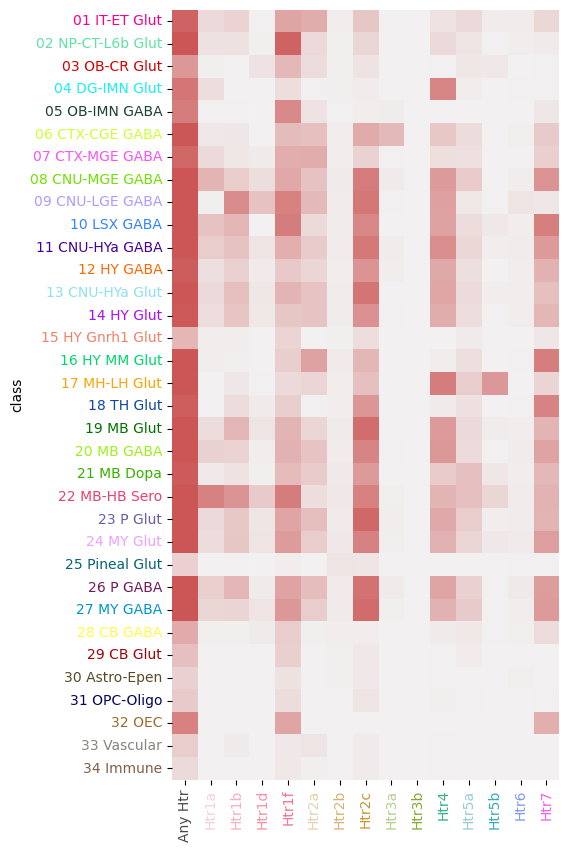

In [48]:
def expr_genes_by_classes(ax): 
    cax = sns.heatmap(joined.groupby("class")[selected_genes].apply(percentage_above_threshold),
                yticklabels=True,  cmap=sns.light_palette("#CC5656", as_cmap=True), ax=ax, cbar=False, vmax=90)
    for ytick in ax.get_xticklabels():
        ytick.set_color(genes_cmap_rgb[ytick.get_text()])
    for ytick in ax.get_yticklabels():
        ytick.set_color(classification_cmap[ytick.get_text()])
        

fig, ax = plt.subplots(figsize=(5,10))
expr_genes_by_classes(ax)

# Correlation

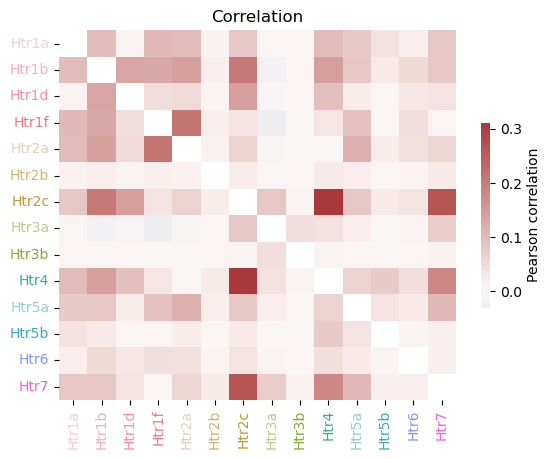

In [49]:
def corr_genes(ax): 
    _ = exp.corr()
    sns.heatmap(_[_<1],  ax=ax, cbar_kws={'label': 'Pearson correlation', "shrink": 0.5}, center=0, cmap="vlag")
    for ytick in ax.get_xticklabels():
        ytick.set_color(genes_cmap_rgb[ytick.get_text()])
    for ytick in ax.get_yticklabels():
        ytick.set_color(genes_cmap_rgb[ytick.get_text()])
    ax.set_title("Correlation")

fig, ax = plt.subplots()
corr_genes(ax)

0it [00:00, ?it/s]

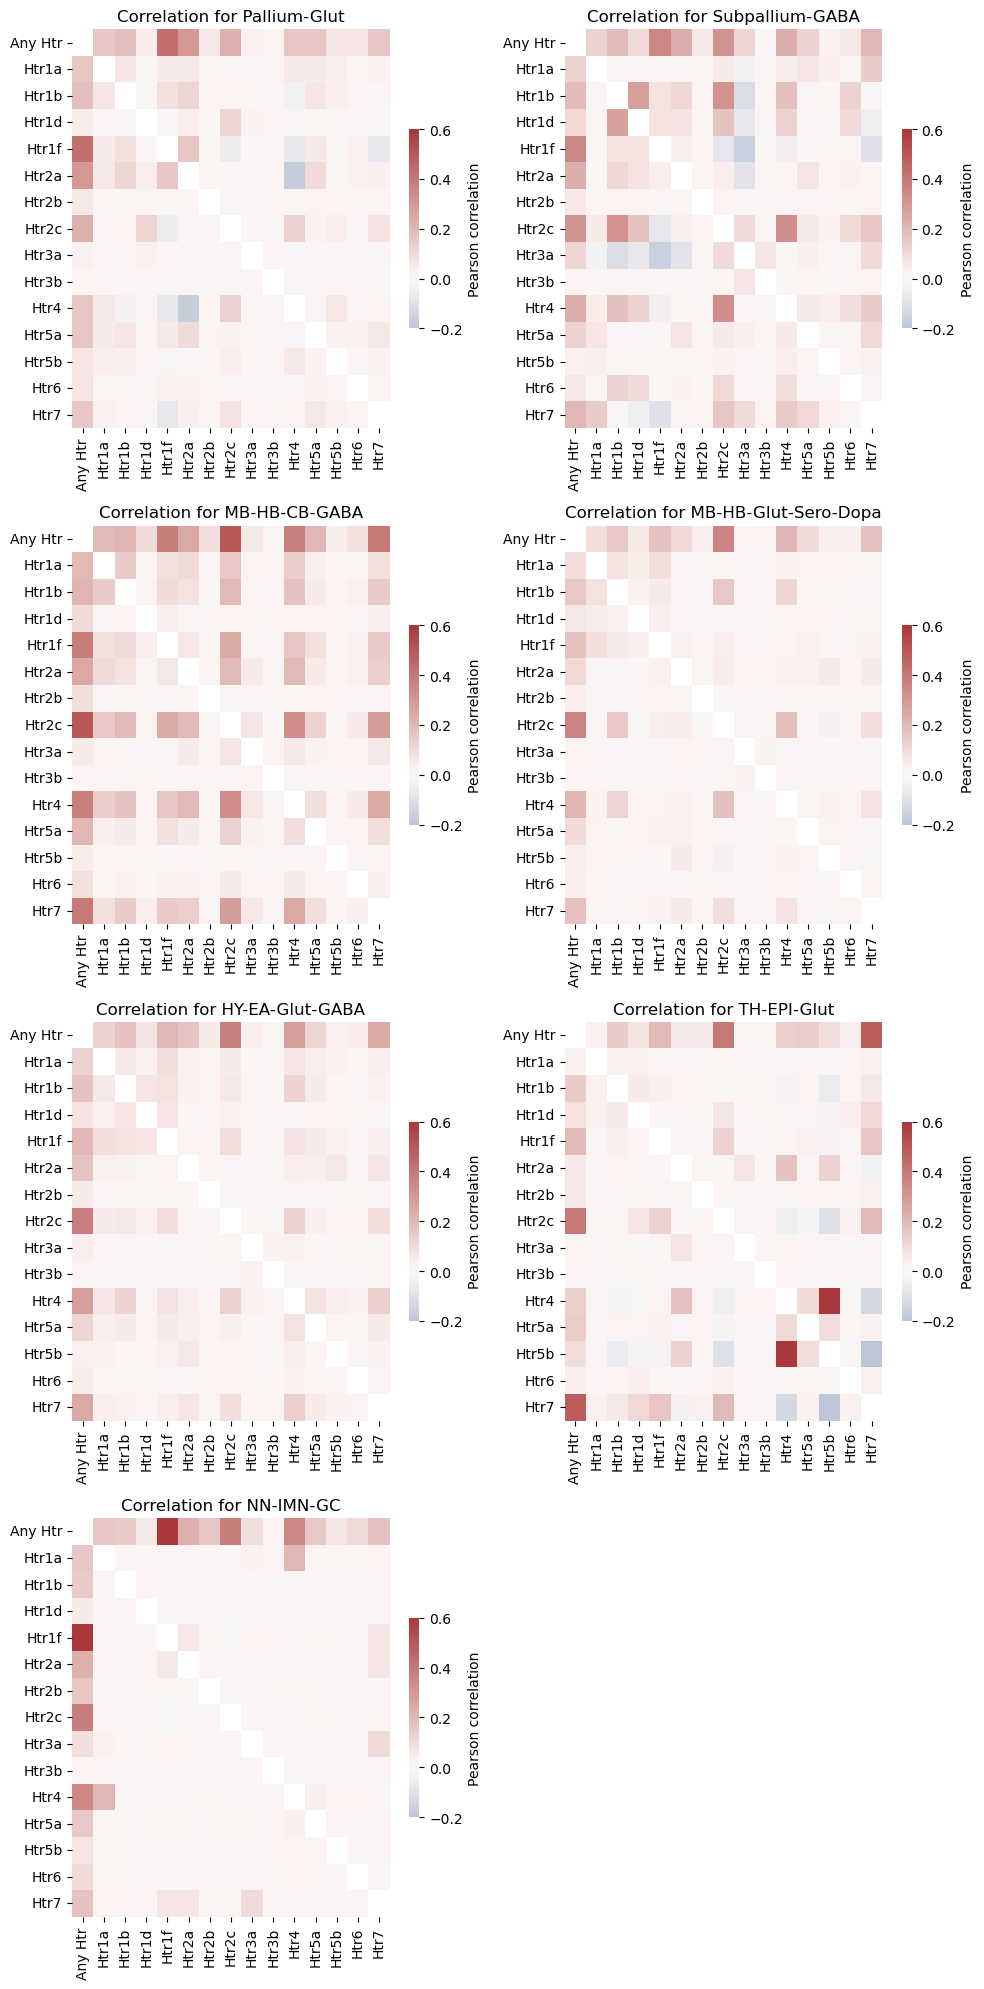

In [50]:
# Create 4x2 subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for i, area in tqdm(enumerate(neuron_cluster_groups_order)):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    subset = joined_with_membership[joined_with_membership["cluster_group_name"] == area]
    correlation = subset[selected_genes].corr()
    sns.heatmap(correlation[correlation < 1], ax=ax, vmin=-.2, vmax=.6,center=0, cbar_kws={'label': 'Pearson correlation', "shrink": 0.5},  cmap="vlag")
    ax.set_title(f"Correlation for {area}")

fig.delaxes(axes[3, 1])
plt.tight_layout()

# Co-expression

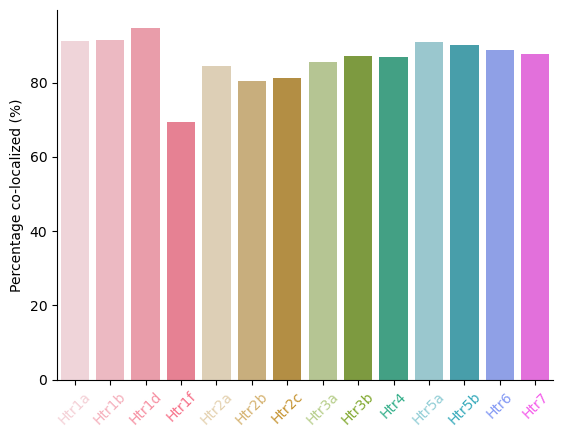

In [206]:
def plot_coloc(data, ax):
    sns.barplot(data=data,x="index", hue="index", palette=genes_cmap, y=data.columns[1], ax=ax)
    ax.set_xlabel("5-HT receptors")
    ax.set_ylabel(data.columns[1])
    ax.tick_params(axis='x', rotation=45)
    plt.draw()
    
    for ytick in ax.get_xticklabels():
        ytick.set_color(genes_cmap_rgb[ytick.get_text()])
    sns.despine()
    ax.set_xlabel("")
    
fig, ax = plt.subplots()
plot_coloc(pd.DataFrame.from_dict(at_least_2_receptors, orient="index", columns=["Percentage co-localized (%)"]).reset_index(), ax)

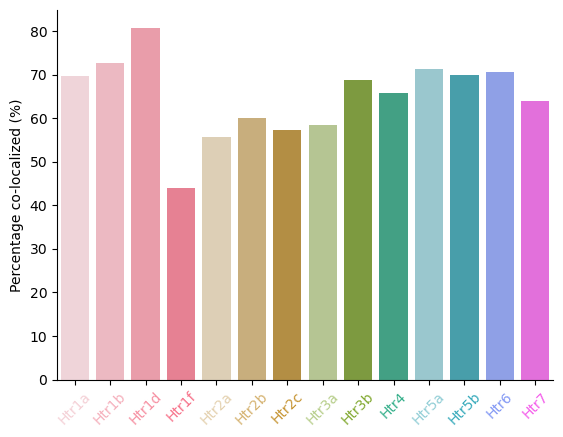

In [199]:

fig, ax = plt.subplots()
plot_coloc(pd.DataFrame.from_dict(at_least_3_receptors, orient="index", columns=["Percentage co-localized (%)"]).reset_index(), ax)

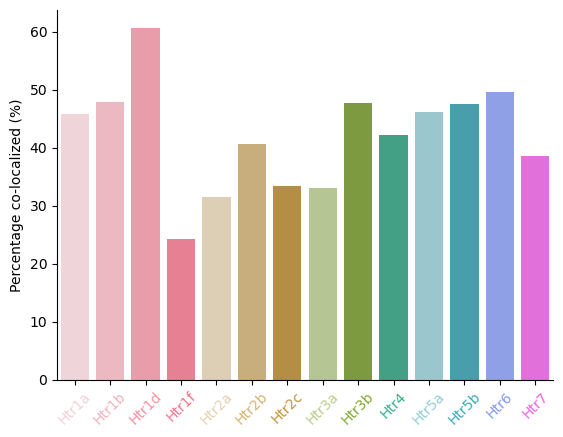

In [53]:

fig, ax = plt.subplots()
plot_coloc(pd.DataFrame.from_dict(at_least_4_receptors, orient="index", columns=["Percentage co-localized (%)"]).reset_index(), ax)

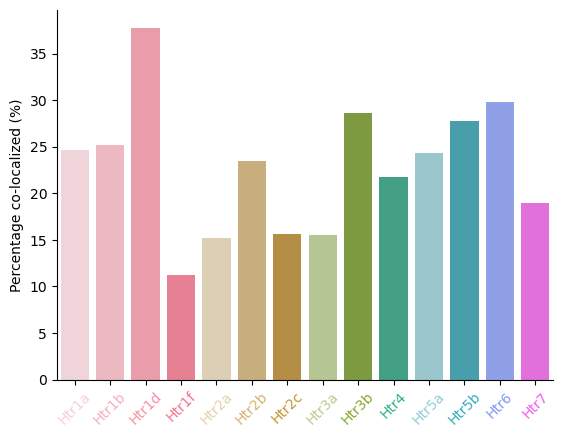

In [54]:

fig, ax = plt.subplots()
plot_coloc(pd.DataFrame.from_dict(at_least_5_receptors, orient="index", columns=["Percentage co-localized (%)"]).reset_index(), ax)

In [55]:
def scatterheat_coloc(ax):
    coloc = pd.read_pickle(f"{output_folder_calculations}/total_colocalization_{family_name}.pkl")
  
    coloc['Gene1'] = pd.Categorical(coloc['Gene1'], categories=selected_genes, ordered=True)
    
    coloc['Gene2'] = pd.Categorical(coloc['Gene2'], categories=selected_genes, ordered=True)
    
    
    ax = sns.scatterplot(data=coloc[coloc["Colocalized (%)"]<100].sort_values(by=["Gene1", "Gene2"]),
            y="Gene1", x="Gene2", hue="Colocalized (%)", size="Colocalized (%)",
            palette="vlag",  edgecolor=".7",  sizes=(1, 150) 
           )
    ax.set(xlabel="", ylabel="")
    sns.despine(ax=ax, left=True, bottom=True)
    ax.margins(.02)
    plt.draw()
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    for label in ax.get_xticklabels():
        # Your code to modify the x-tick labels goes here
        label.set_color(genes_cmap_rgb[label.get_text()])
    for label in ax.get_yticklabels():
        # Your code to modify the x-tick labels goes here
        label.set_color(genes_cmap_rgb[label.get_text()])
    # Adjust legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [f"{label}%" if label.isdigit() else label for label in labels]
    ax.legend(handles, new_labels, bbox_to_anchor=(1, 0.7), ncol=1,  handletextpad=0, labelspacing=0.5, borderpad=0.3)
    ax.set_title("Co-localization")

## Co-localization (percentage cells expressing y receptor also express x receptor?)

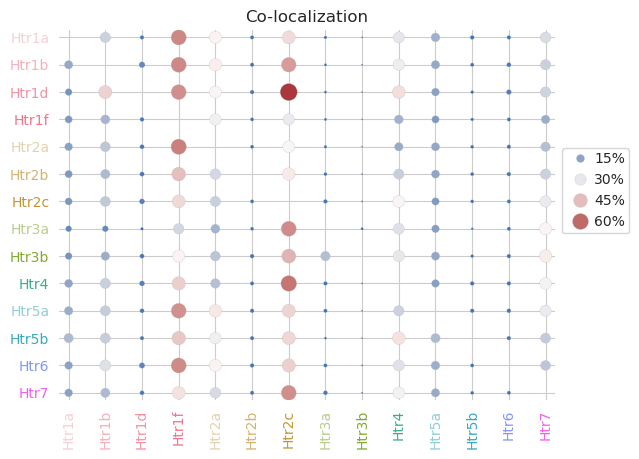

In [56]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots()
    scatterheat_coloc(ax)

In [93]:
%%time
by_fam = pd.concat([joined_with_membership[['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f','Htr5a', 'Htr5b']].sum(axis=1),
              joined_with_membership[['Htr2a',
       'Htr2b', 'Htr2c']].sum(axis=1),
              joined_with_membership[['Htr4','Htr6',
       'Htr7']].sum(axis=1),
              joined_with_membership[['Htr3a','Htr3b']].sum(axis=1), joined_with_membership["class"], joined_with_membership["subclass"], joined_with_membership["supertype"], joined_with_membership["cluster_group_name"], by_fam[["Htr1/5", "Htr2", "Htr4/6/7", "Htr3"]].idxmax(axis=1)], axis=1)
by_fam.columns = ["Htr1/5", "Htr2", "Htr4/6/7", "Htr3", "class", "subclass", "supertype","cluster_group_name", "Primary Htr family"]

CPU times: user 6.78 s, sys: 896 ms, total: 7.68 s
Wall time: 7.67 s


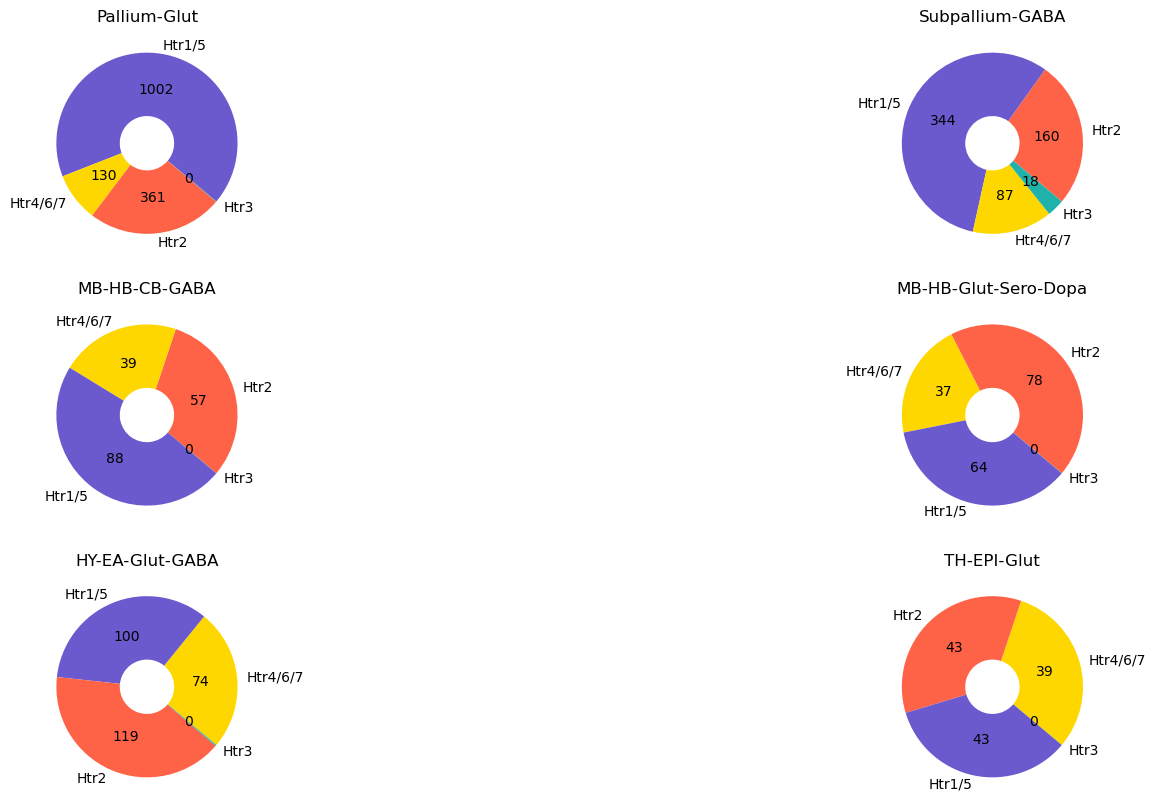

In [150]:

def pie_plots(axs):
    axs = axs.flatten()  # Flatten the array of axes for easy indexing
    
    def absolute_value(val, data):
        a = round(val/100.*data.sum(), 0)/1000
        return int(a)
        
    for i, group in enumerate(['Pallium-Glut',
     'Subpallium-GABA',
     'MB-HB-CB-GABA',
     'MB-HB-Glut-Sero-Dopa',
     'HY-EA-Glut-GABA',
     'TH-EPI-Glut']):
        group_data = by_fam[by_fam["cluster_group_name"] == group]
        values = group_data["Primary Htr family"].value_counts(sort=False)
        labels = values.index
        colors = [general_cmap[label] for label in labels if label in general_cmap]
    
        axs[i].pie(values, labels=labels, autopct=lambda val: absolute_value(val, values), 
                   wedgeprops=dict(width=0.7), startangle=-40, colors=colors)
        axs[i].set_title(group)
    
    # Hide the unused subplot
    axs[-1].axis('off')
    
fig, axs = plt.subplots(3, 2, figsize=(20, 10))  # 2 rows, 4 columns
pie_plots(axs)

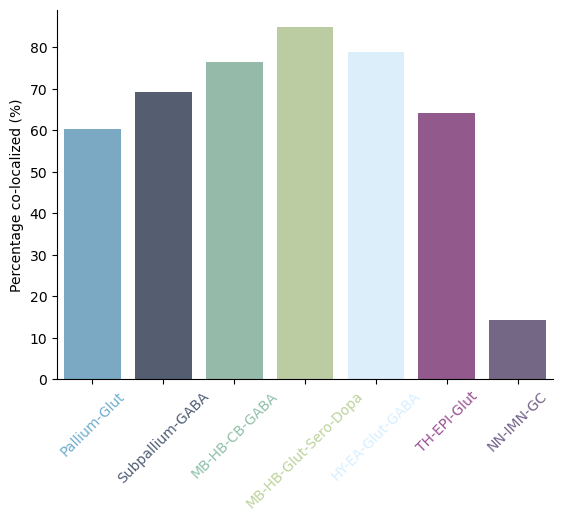

In [60]:
def plot_coloc_by_group( ax):
    sns.barplot(data=pd.DataFrame.from_dict(at_least_2_receptors_per_group, orient="index", columns=["Percentage co-localized (%)"]).reset_index(),x="index", hue="index",  palette=cluster_groups_cmap, ax=ax, order = neuron_cluster_groups_order, y="Percentage co-localized (%)")
    
    ax.tick_params(axis='x', rotation=45)
    sns.despine(ax=ax)
    plt.draw()
    for label in ax.get_xticklabels():
        # Your code to modify the x-tick labels goes here
        label.set_color(cluster_groups_cmap[label.get_text()])
    ax.set_xlabel("")
fig, ax = plt.subplots()
plot_coloc_by_group( ax)

# Figure 1

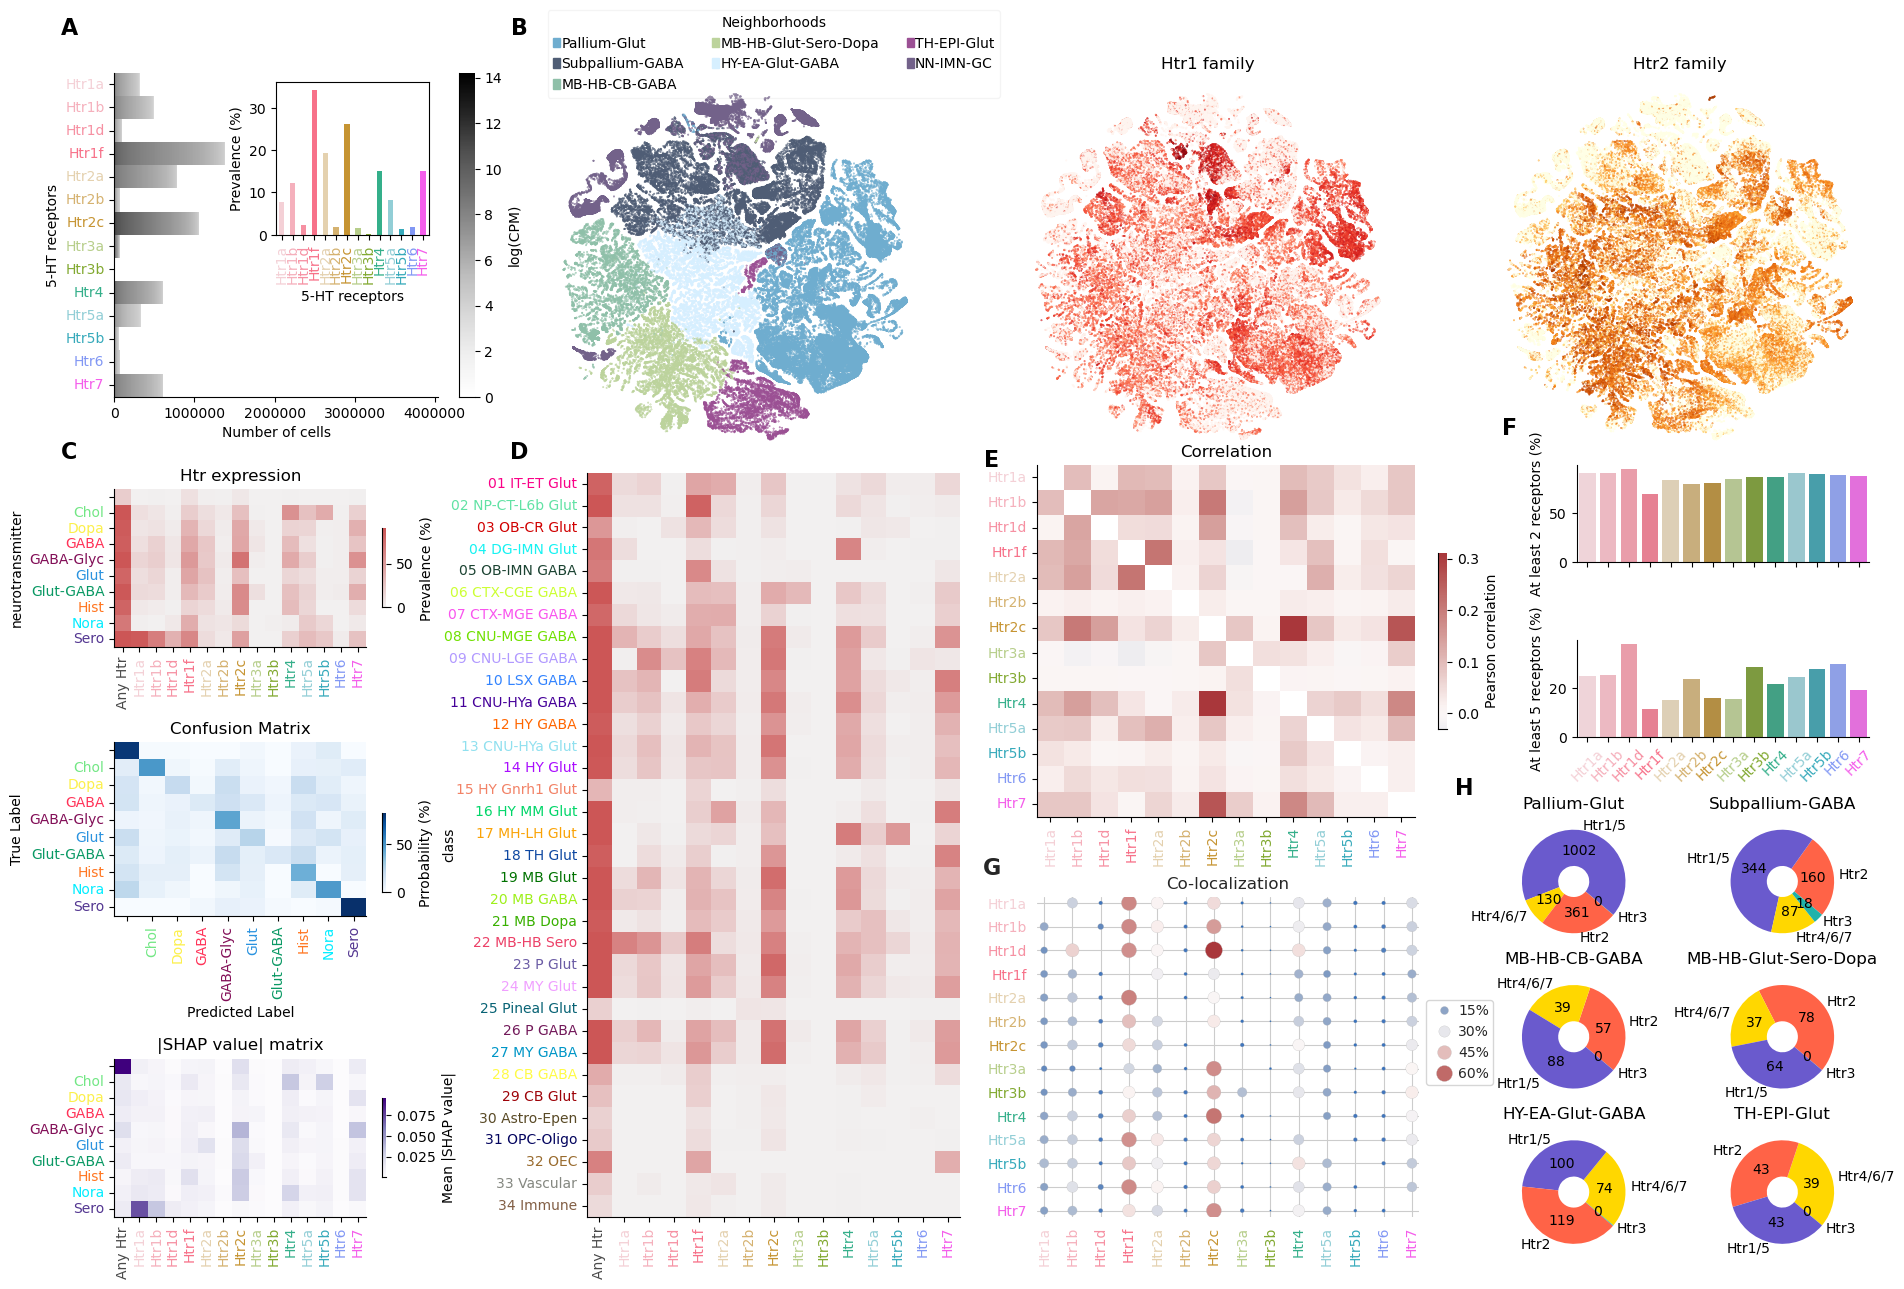

In [215]:
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(4, 4, figure=fig, height_ratios=(1,.5,.5,1))

subfig = fig.add_subfigure(gs[0,0])
ax = subfig.subplots()
subfig.suptitle("A", x=-.0, y=1.1, fontsize=16, fontweight='bold');
subfig.subplots_adjust(wspace=0,left=0.1, bottom=.15, top=.96, right=1)
expr_genes_whole_brain(ax, exp)

subfig = fig.add_subfigure(gs[0,1:])
axs = subfig.subplots(1,3)
subfig.suptitle("B", x=0, y=1.1, fontsize=16, fontweight='bold');
subfig.subplots_adjust(wspace=0.25, left=0.02, bottom=0, top=.95, right=1)
diff_umap(axs)
diff_umap_ABC_groups(axs[0])
subfig.set_facecolor('none')

subfig = fig.add_subfigure(gs[1:4,0])
axs = subfig.subplots(3)
subfig.suptitle("C", x=0, y=1.02, fontsize=16, fontweight='bold');
sel="neurotransmitter"
expr_genes_by_sel(axs, sel,joined, cm_neurotransmitter, shap_matrix_neurotransmitter)
subfig.subplots_adjust(hspace=0.8, left=0.1, bottom=0.05, top=.96, right=.8) 
pos = axs[1].get_position()

# Modify the position parameters as needed (left, bottom, width, height)
# For example, to move the subplot up and increase its height:
new_pos = [pos.x0, pos.y0 + 0.02, pos.width, pos.height + 0.02]

# Set the new position
axs[1].set_position(new_pos)

subfig = fig.add_subfigure(gs[1:4,1])
axs = subfig.subplots()
subfig.suptitle("D", x=0, y=1.02, fontsize=16, fontweight='bold');
subfig.subplots_adjust(left=.15, bottom=0.05, top=.98, right=.98)
expr_genes_by_classes(axs)
axs.yaxis.set_label_coords(-0.35, 0.5) 

subfig = fig.add_subfigure(gs[1:3,2])
ax = subfig.subplots()
subfig.suptitle("E", x=0.05, y=1.02, fontsize=16, fontweight='bold');
subfig.subplots_adjust(left=0.15, bottom=.1, top=.98, right=1.2)
corr_genes(ax)
subfig.set_facecolor('none')

subfig = fig.add_subfigure(gs[1:3,3])
axs = subfig.subplots(2)
subfig.suptitle("F", x=.2, y=1.1, fontsize=16, fontweight='bold');
subfig.subplots_adjust( left=0.35, bottom=.3, top=.98, right=1)
plot_coloc(pd.DataFrame.from_dict(at_least_2_receptors, orient="index", columns=["At least 2 receptors (%)"]).reset_index(), axs[0])
axs[0].set_xticklabels("");
plot_coloc(pd.DataFrame.from_dict(at_least_5_receptors, orient="index", columns=["At least 5 receptors (%)"]).reset_index(), axs[1])
subfig.set_facecolor('none')

with sns.axes_style("whitegrid"):
    subfig = fig.add_subfigure(gs[3,2])
    ax = subfig.subplots()
    subfig.suptitle("G", x=.05, y=1, fontsize=16, fontweight='bold');
    subfig.subplots_adjust(left=.15, bottom=.1, top=.9, right=1)
    scatterheat_coloc(ax)
    subfig.set_facecolor('none')

subfig = fig.add_subfigure(gs[3,3])
axs = subfig.subplots(3, 2)
subfig.suptitle("H", x=.1, y=1.2, fontsize=16, fontweight='bold');
subfig.subplots_adjust( top=1.1,bottom=0, right=1, wspace=0.2, hspace=0.2)
pie_plots(axs)
subfig.set_facecolor('none')

In [217]:
fig.savefig(Path(output_folder, 'Figure_1.png'), bbox_inches='tight', dpi=300)

## Supp

## 1

In [15]:
from scipy.stats import pearsonr as pearsonr
from scipy.stats import linregress


data = pd.concat([exp[exp>0].mean(), (((exp>threshold_expression).sum(axis=0)/exp.shape[0])*100)], axis=1)
data.columns = ["log(CPM)", "Prevalence (%)"]


def plot_supp_1(axs, data):
    sns.scatterplot(data=data.reset_index(), x="log(CPM)", y= "Prevalence (%)", hue="index", palette=genes_cmap_rgb, ax=axs[0])
    
    sns.regplot(data=data, x="log(CPM)", y= "Prevalence (%)", scatter=False, line_kws={ "color": "k", "alpha": .5}, ax=axs[0])
    
    sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
    
    r, p = pearsonr(data["log(CPM)"], data["Prevalence (%)"])
    
    s,_,_,_,_ = linregress(data["log(CPM)"], data["Prevalence (%)"])
    
    plt.text(.1, .8, f"R\u00b2={round(r ** 2, 2)}, p-value={'{:.2e}'.format(p)}, slope= {round(s,2)}", horizontalalignment='left',
            size="small", color='black', weight='semibold', transform = axs[0].transAxes, zorder=100)
    if p<.05:
        plt.text(.1, .85, "*", size=15, color='black', weight='semibold', transform = axs[0].transAxes, zorder=10)
    
    sns.violinplot(exp[exp>0].loc[:,exp[exp>0].mean().sort_values(ascending=False).index], palette=genes_cmap_rgb, ax=axs[1])
    plt.draw()
    for xtick in axs[1].get_xticklabels():
        xtick.set_color(genes_cmap_rgb[xtick.get_text()])
        xtick.set_rotation(90)
    axs[1].set_ylabel("Log(CPM)")

#plt.tight_layout()


In [12]:
df = joined_with_membership

In [13]:
crosstab_neurotrans_neigh = pd.crosstab(df['neurotransmitter'], df['cluster_group_name'], normalize="index")*100
crosstab_neurotrans_class = pd.crosstab(df['neurotransmitter'], df['class'], normalize="index")*100
crosstab_neigh_class = pd.crosstab(df['cluster_group_name'], df['class'], normalize="index")*100

CPU times: user 3min 29s, sys: 1min 50s, total: 5min 20s
Wall time: 2min 53s


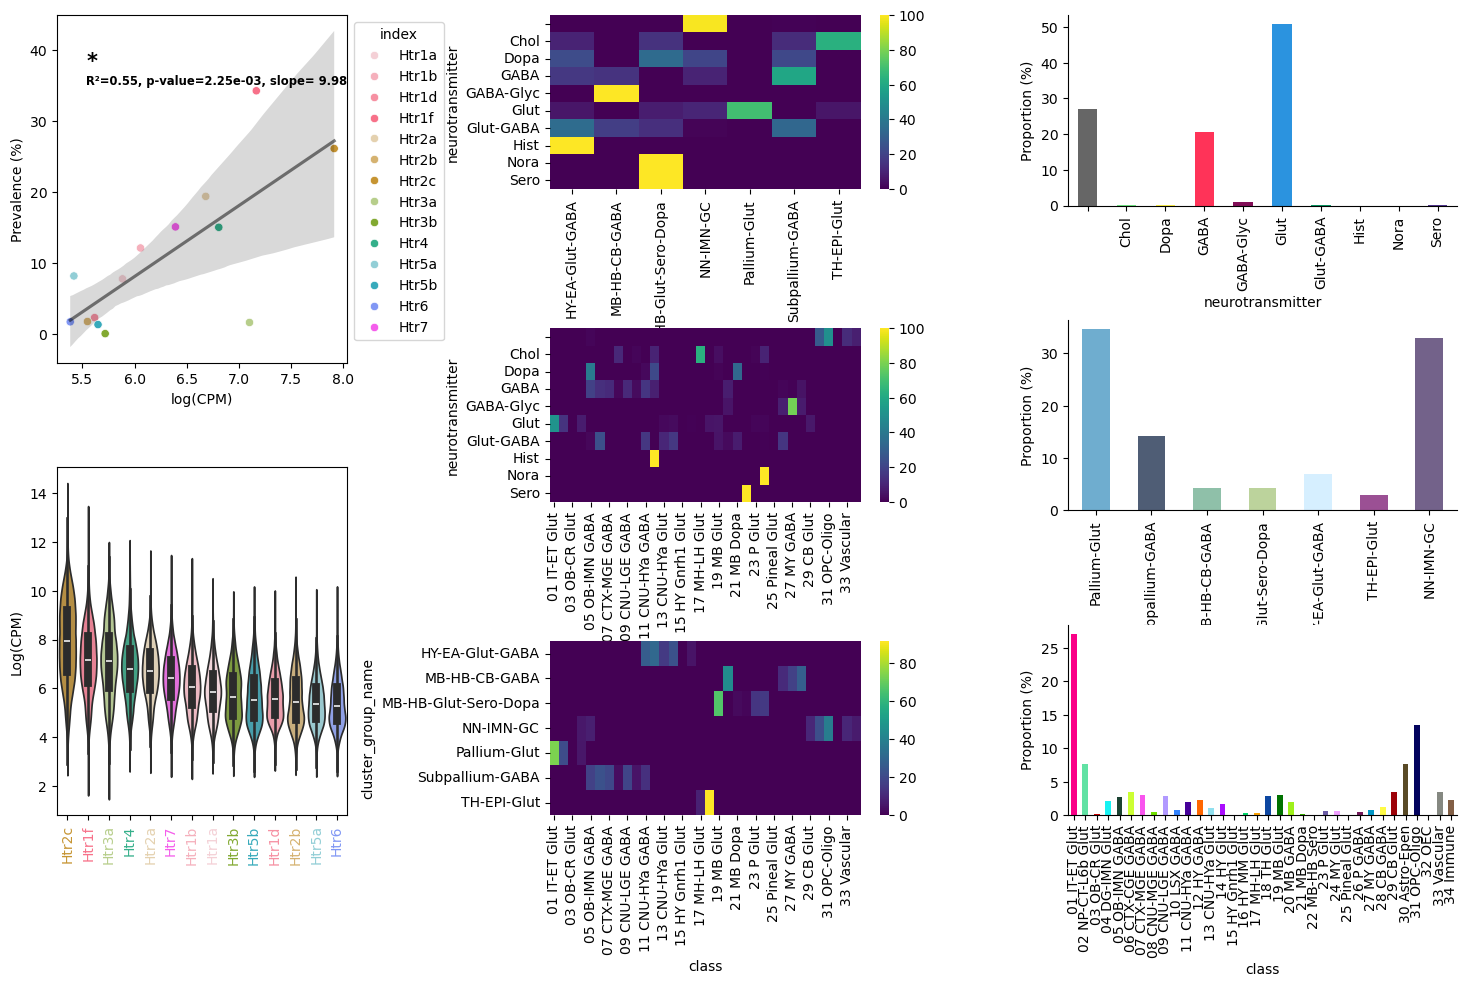

In [28]:
%%time
fig = plt.figure(figsize=(14, 8))

gs = gridspec.GridSpec(3, 3, figure=fig, width_ratios=[.7,1,1])

subfig = fig.add_subfigure(gs[0:,0])
subfig.subplots_adjust( left=0, bottom=0, top=1, right=.8, hspace=0.3)
subfig.suptitle("A", x=0.05, y=1.02, fontsize=16, fontweight='bold');
axs = subfig.subplots(2)
plot_supp_1(axs, data)

subfig = fig.add_subfigure(gs[0:,1])
subfig.subplots_adjust( left=0.25, bottom=0, top=1, right=1, hspace=0.8)
subfig.suptitle("B", x=0.05, y=1.02, fontsize=16, fontweight='bold');
axs = subfig.subplots(3)

sns.heatmap(crosstab_neurotrans_neigh, ax=axs[0], cmap="viridis")
sns.heatmap(crosstab_neurotrans_class, ax=axs[1], cmap="viridis")
sns.heatmap(crosstab_neigh_class, ax=axs[2], cmap="viridis")

subfig = fig.add_subfigure(gs[0:,2])
subfig.subplots_adjust(left=0.25, bottom=0, top=1, right=1, hspace=0.6)
subfig.suptitle("C", x=0.05, y=1.02, fontsize=16, fontweight='bold');
axs = subfig.subplots(3)

grouped_data = (joined.groupby("class").size()/joined.shape[0])*100

# Plot the ordered data
grouped_data.plot.bar(color=[classification_cmap[group] for group in grouped_data.index], ax=axs[2])

grouped_data = (joined.groupby("neurotransmitter").size() / joined.shape[0]) * 100

# Plot the ordered data
grouped_data.plot.bar(color=[neurotransmitter_color_map[group] for group in grouped_data.index], ax=axs[0])

# Group and calculate the percentage
grouped_data = (joined_with_membership.groupby("cluster_group_name").size() / joined_with_membership.shape[0]) * 100

# Reindex the grouped data to match the order specified in neuron_cluster_groups_order
ordered_data = grouped_data.reindex(neuron_cluster_groups_order)

# Plot the ordered data
ordered_data.plot.bar(color=[cluster_groups_cmap[group] for group in ordered_data.index if group in cluster_groups_cmap], ax=axs[1])

for ax in axs:
    ax.set_ylabel("Proportion (%)")
    sns.despine(ax=ax)


## 2

In [175]:
k = len(selected_genes) + 6

# Calculate number of rows for the grid
ncols = 3
nrows = int(np.ceil(k / ncols))

# Create a figure with the desired overall width and height
fig, axs = plt.subplots(nrows,ncols,figsize=(25,45))

for n, item in enumerate(["neurotransmitter", "class"]):      
    _ = subsampled[[item, item + "_color"]].drop_duplicates()
    _ = _.sort_values(item)
    # Create custom legend elements
    legend_elements = [mpatches.Patch(color=row[item + '_color'], label=row[item]) for x, row in _.iterrows()]
    axs[0,n].legend(handles=legend_elements, ncol=3, loc="center")

_ = subsampled[["region_of_interest_acronym", "region_of_interest_color"]].drop_duplicates()
_ = _.sort_values("region_of_interest_acronym")
# Create custom legend elements
legend_elements = [mpatches.Patch(color=row["region_of_interest_color"], label=row["region_of_interest_acronym"]) for x, row in _.iterrows()]
axs[0,2].legend(handles=legend_elements, ncol=3, loc="center")

axs[1,0].scatter(subsampled['x'], subsampled['y'], c=subsampled['neurotransmitter_color'], s=0.5, marker='.')
axs[1,0].set_title("Neurotransmitter") 
axs[1,2].scatter(subsampled['x'], subsampled['y'], c=subsampled['region_of_interest_color'], s=0.5, marker='.')
axs[1,2].set_title("Region") 
axs[1,1].scatter(subsampled['x'], subsampled['y'], c=subsampled['class_color'], s=0.5, marker='.')
axs[1,1].set_title("Class") 

for n, gene in enumerate(selected_genes):
    row = n // ncols
    col = n % ncols
    sc = axs[row + 2, col ].scatter(subsampled['x'], subsampled['y'], c=subsampled[gene], s=0.5, marker='.', cmap="rocket_r")
    axs[row + 2, col].set_title(gene) 

for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()

In [28]:
'''fig, axs = plt.subplots(2,3, figsize=(30,15))

sns.heatmap(expression_by_neurotransmitter.T.corr(), cmap="vlag", center=0, ax=axs[0,0], cbar=0)
sns.heatmap(expression_by_group.T.corr(),  cmap="vlag", center=0, ax=axs[0,1], cbar=0)
sns.heatmap(expression_by_class.T.corr(),  cmap="vlag", center=0, ax=axs[0,2], cbar=1)

sns.barplot(corr_by_neurotransmitter, palette=neurotransmitter_color_map, ax=axs[1,0])


# Reindex the grouped data to match the order specified in neuron_cluster_groups_order
ordered_data = corr_by_group.loc[neuron_cluster_groups_order]

sns.barplot(ordered_data, palette=cluster_groups_cmap, ax=axs[1,1])
# Plot the ordered data

sns.barplot(corr_by_class, palette=classification_cmap, ax=axs[1,2])

for ax in [axs[1,2], axs[1,1], axs[1,0]]:
    ax.set_ylabel("Mean r")

for ax in [axs[0,2], axs[0,1], axs[0,0]]:
    ax.set_title("Correlation matrix")
    
sns.despine()
plt.tight_layout()'''

'fig, axs = plt.subplots(2,3, figsize=(30,15))\n\nsns.heatmap(expression_by_neurotransmitter.T.corr(), cmap="vlag", center=0, ax=axs[0,0], cbar=0)\nsns.heatmap(expression_by_group.T.corr(),  cmap="vlag", center=0, ax=axs[0,1], cbar=0)\nsns.heatmap(expression_by_class.T.corr(),  cmap="vlag", center=0, ax=axs[0,2], cbar=1)\n\nsns.barplot(corr_by_neurotransmitter, palette=neurotransmitter_color_map, ax=axs[1,0])\n\n\n# Reindex the grouped data to match the order specified in neuron_cluster_groups_order\nordered_data = corr_by_group.loc[neuron_cluster_groups_order]\n\nsns.barplot(ordered_data, palette=cluster_groups_cmap, ax=axs[1,1])\n# Plot the ordered data\n\nsns.barplot(corr_by_class, palette=classification_cmap, ax=axs[1,2])\n\nfor ax in [axs[1,2], axs[1,1], axs[1,0]]:\n    ax.set_ylabel("Mean r")\n\nfor ax in [axs[0,2], axs[0,1], axs[0,0]]:\n    ax.set_title("Correlation matrix")\n    \nsns.despine()\nplt.tight_layout()'

In [71]:
sel = "cluster_group_name"#"class"#"cluster_group_name"#"neurotransmitter"

cm_neighborood, shap_matrix_neighborood, accuracy_neighborood, report_neighborood = decoddddddd(joined_boolean_with_membership, sel);

Accuracy: 50.937220375444504

Classification Report:
                       precision    recall  f1-score   support

     HY-EA-Glut-GABA       0.24      0.18      0.21     14772
       MB-HB-CB-GABA       0.20      0.10      0.13      9339
MB-HB-Glut-Sero-Dopa       0.17      0.42      0.24      9033
           NN-IMN-GC       0.71      0.73      0.72     70927
        Pallium-Glut       0.60      0.56      0.58     74740
     Subpallium-GABA       0.66      0.15      0.25     30571
         TH-EPI-Glut       0.16      0.71      0.26      6309

            accuracy                           0.51    215691
           macro avg       0.39      0.41      0.34    215691
        weighted avg       0.57      0.51      0.51    215691



## 3

In [63]:
sel = "class"#"class"#"cluster_group_name"#"neurotransmitter"

cm_class, shap_matrix_class, accuracy_class, report_class = decoddddddd(joined_boolean, sel);

Accuracy: 16.09555328000633


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Classification Report:
                    precision    recall  f1-score   support

    01 IT-ET Glut       0.74      0.18      0.29     54774
02 NP-CT-L6b Glut       0.39      0.13      0.19     15510
    03 OB-CR Glut       0.03      0.07      0.04       238
   04 DG-IMN Glut       0.30      0.59      0.40      4218
   05 OB-IMN GABA       0.12      0.50      0.20      5375
  06 CTX-CGE GABA       0.70      0.31      0.43      6952
  07 CTX-MGE GABA       0.12      0.05      0.07      6104
  08 CNU-MGE GABA       0.04      0.20      0.07       942
  09 CNU-LGE GABA       0.36      0.54      0.43      5758
      10 LSX GABA       0.10      0.27      0.14      1516
  11 CNU-HYa GABA       0.15      0.09      0.11      3924
       12 HY GABA       0.05      0.11      0.07      4519
  13 CNU-HYa Glut       0.12      0.02      0.04      2284
       14 HY Glut       0.17      0.03      0.05      3349
 15 HY Gnrh1 Glut       0.00      0.00      0.00        10
    16 HY MM Glut       0.03  

In [64]:
report_class = pd.DataFrame(report_class)#.loc["recall"]

In [65]:
report_class.loc["recall"][report_class.loc["recall"]>.5].index.values

array(['04 DG-IMN Glut', '09 CNU-LGE GABA', '17 MH-LH Glut', '34 Immune'],
      dtype=object)

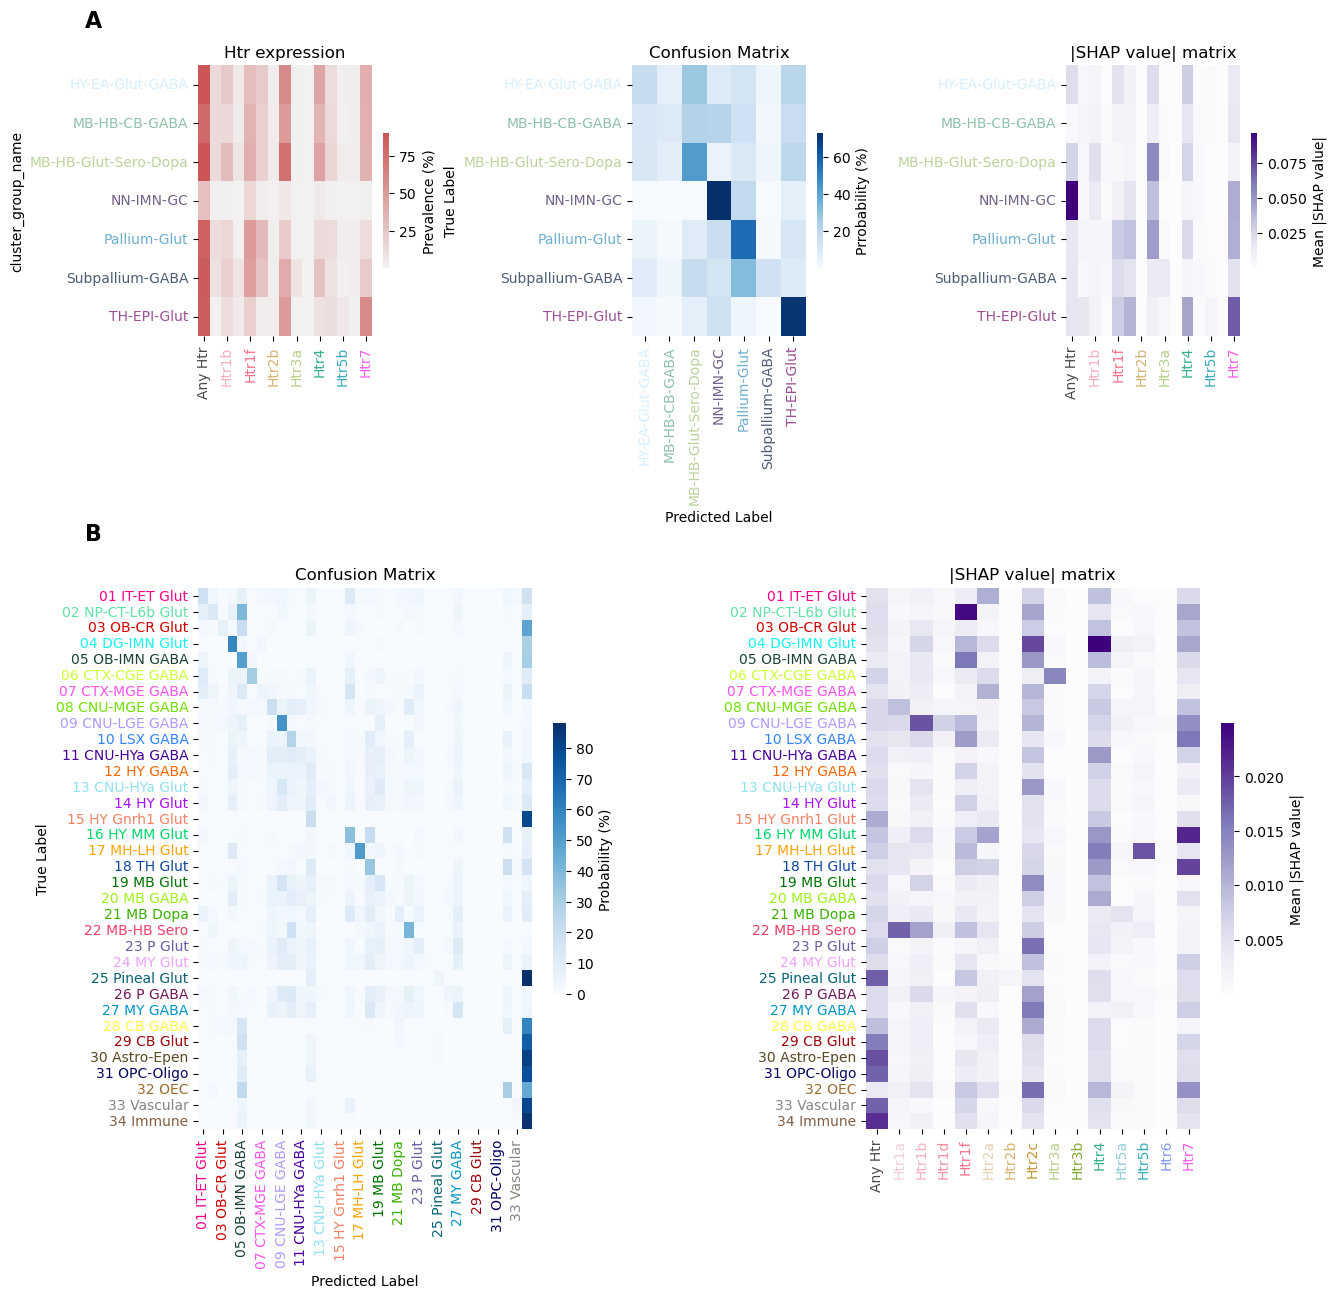

In [84]:
fig = plt.figure(figsize=(14, 14))

gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[.5,1])

subfig = fig.add_subfigure(gs[0,0:])
subfig.subplots_adjust(bottom=.3, wspace=1)
subfig.suptitle("A", x=0.05, y=1.0, fontsize=16, fontweight='bold');
axs = subfig.subplots(1, 3)
expr_genes_by_sel(axs, sel,joined_with_membership, cm_neighborood, shap_matrix_neighborood)

subfig = fig.add_subfigure(gs[1,0:])
subfig.subplots_adjust( wspace=0.6)
subfig.suptitle("B", x=0.05, y=.95, fontsize=16, fontweight='bold');
axs = subfig.subplots(1, 2)

sns.heatmap(cm_class, cmap="Blues", ax=axs[0], cbar_kws={'label': 'Probability (%)', "shrink": 0.5, "location": "right", "pad":0.05})
axs[0].set_title('Confusion Matrix')
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')

sns.heatmap(shap_matrix_class, cmap="Purples", ax=axs[1], cbar_kws={'label': 'Mean |SHAP value|', "shrink": 0.5, "location": "right", "pad":0.05})
axs[1].set_title('|SHAP value| matrix')

for ax in axs:
    for ytick in ax.get_xticklabels():
        if ytick.get_text() in list(general_cmap.keys()):
            ytick.set_color(general_cmap[ytick.get_text()])
    for ytick in ax.get_yticklabels():
        if ytick.get_text() in list(general_cmap.keys()):
            ytick.set_color(general_cmap[ytick.get_text()])


In [50]:
import umap

In [51]:
#%%time
#umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=50)
#umap_results = umap_model.fit_transform(X)
#pd.DataFrame(umap_results, columns=["UMAP1", "UMAP2"]).to_csv(Path(output_folder_calculations,"umap"))

CPU times: user 2d 16h 17min 47s, sys: 7h 33min 18s, total: 2d 23h 51min 6s
Wall time: 1h 39min 7s


In [55]:
# Replace 'your_file.csv' with the path to your CSV file
umap_df = pd.read_csv(Path(output_folder_calculations,"umap"))[["UMAP1", "UMAP2"]]

umap_df

UMAP1      UMAP2
0         1.662688 -16.558794
1         5.467614  22.414830
2        10.389254  -0.062215
3         5.568335  11.825956
4         2.470335 -18.450180
...            ...        ...
4042971  -3.891196  -6.268229
4042972   7.430809  -1.129128
4042973  11.338645 -11.697423
4042974  -0.351575  20.795698
4042975   3.705679   4.007321

[4042976 rows x 2 columns]

In [74]:
_

Htr1a  Htr1b  Htr1d  Htr1f  Htr2a  Htr2b  Htr2c  Htr3a  Htr3b   Htr4  \
1435121  False  False  False  False  False  False  False  False  False  False   
1714193  False  False  False  False  False  False  False  False  False  False   
1467430  False  False  False   True  False  False  False  False  False  False   
1989377  False  False  False  False  False  False  False  False  False  False   
1163515  False   True  False   True   True  False  False  False  False  False   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1501639  False  False  False  False  False  False  False  False  False  False   
840859   False  False  False  False  False  False  False  False  False  False   
2196803  False  False  False  False  False  False  False  False  False  False   
3350606  False   True  False   True  False  False  False  False  False  False   
1866643  False  False  False  False  False  False  False  False  False  False   

         Htr5a  Htr5b   Htr6   Htr7      UMAP1      UMAP2  
1435121  False  False  False  False   4.108610   3.891458  
1714193  False  False  False  False   3.688423   4.124610  
1467430  False  False  False  False  16.623638   8.350761  
1989377  False  False  False  False   4.583038   3.375514  
1163515  False  False  False  False -10.396248  -6.234476  
...        ...    ...    ...    ...        ...        ...  
1501639  False  False  False  False   5.450530   5.426191  
840859   False  False  False  False   4.948157   3.576015  
2196803  False  False  False  False   3.824911   4.649150  
3350606  False  False  False  False   7.012582 -15.848070  
1866643  False  False  False  False   5.333196   5.569049  

[20000 rows x 16 columns]

In [68]:
cells_umap = pd.concat([X.reset_index(drop=True), umap_df], axis=1)

  0%|          | 0/14 [00:00<?, ?it/s]

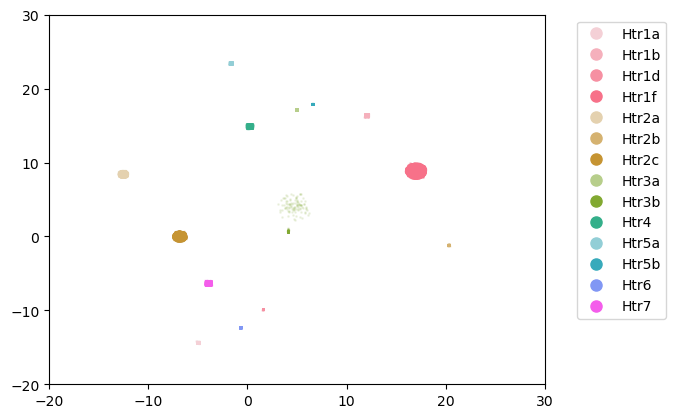

In [118]:
__ = _[_[['Htr1a', 'Htr1b', 'Htr1d', 'Htr2a', 'Htr1f', 'Htr2b', 'Htr2c', 'Htr3a', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7']].sum(axis=1)==1]


fig, ax = plt.subplots()  # Adjust figsize as needed
# Plot each gene in its own subplot
for i, gene in enumerate(tqdm(X.columns), start=1):
    ___ = __[__[gene] == True]
    ax.scatter(___["UMAP1"], ___["UMAP2"], color=general_cmap[gene], s=1, alpha=.1, label=gene)
    ax.set_xlim([-20, 30])
    ax.set_ylim([-20, 30])


legend_handles = []
for gene in X.columns:
    handle = mlines.Line2D([], [], color=general_cmap[gene], marker='o', linestyle='None', markersize=8, label=gene)
    legend_handles.append(handle)

# Adding the legend outside of the last plot
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')



In [111]:
%%time
import matplotlib.lines as mlines

_ = cells_umap.sample(n=2000000, random_state=4)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))  # Adjust figsize as needed
axes = axes.flatten()

# Plot all cells in the first subplot
axes[0].scatter(_["UMAP1"], _["UMAP2"], color='gray', s=1, alpha=.1)
axes[0].set_xlim([-20, 30])
axes[0].set_ylim([-20, 30])
axes[0].set_title("All Cells")

# Plot each gene in its own subplot
for i, gene in enumerate(tqdm(X.columns), start=1):
    ax = axes[i % len(axes)]  # Use modulo for safety
    __ = _[_[gene] == True]
    ax.scatter(__["UMAP1"], __["UMAP2"], color=general_cmap[gene], s=1, alpha=.1)
    ax.set_xlim([-20, 30])
    ax.set_ylim([-20, 30])
    ax.set_title(gene)
    
# Plot for 'No Htr' in the last subplot
__ = _[~_[['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2b', 'Htr2c', 'Htr3a', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7']].any(axis=1)]
axes[-1].scatter(__["UMAP1"], __["UMAP2"], color=".15", s=1, alpha=.1)
axes[-1].set_xlim([-20, 30])
axes[-1].set_ylim([-20, 30])
axes[-1].set_title("No Htr")

plt.tight_layout()
sns.despine()
plt.show()

  0%|          | 0/14 [00:00<?, ?it/s]

CPU times: user 4.58 s, sys: 346 ms, total: 4.93 s
Wall time: 4.55 s
